# Note

Session 2 ended before Tasks 4, 6 & 7 were completed. Feedback that we got:

- Use the code in this notebook to produce new, different database files.
- Use target encoding for "native-country" instead of one-hot encoding (you will see that the result has many less columns).
- Never use the whole adult dataset, only the first 5000 entries.
- Regarding Task 7, it is easy to guess which features are important (an appropriate graph could confirm our suspicions e.g. age, gender, ...).
- The missing steps can be redone in the final report

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
db = pd.read_csv('data/adult.csv')
df = pd.DataFrame(db)

# Tasks

[Task 1](#Task-1) : 
[1.1. Missing Values](#Subtask-1.1.-Checking-for-missing-values-and-handling-them), 
[1.2. Noise, inconsistencies, duplicates](#Subtask-1.2.-Checking-for-noisy-data,-inconsistencies-&-duplicate-entries), 
[1.2.1 Noisy data](#Subsubtask-1.2.1-Checking-for-noisy-data), 
[1.2.2 Inconsistencies](#Subsubtask-1.2.2-Checking-for-inconsistencies), 
[1.2.3 Duplicates](#Subsubtask-1.2.3-Checking-for-duplicates)

[Task 2](#Task-2), 
[Task 3](#Task-3), 
[Task 4 (Missing)](#Task-4), 
[Task 5](#Task-5), 
[Task 6 (Missing)](#Task-6), 
[Task 7 (Missing)](#Task-7)

# Task 1

>Check for missing values in the dataset and handle them \[...\] ([1.1.](#Subtask-1.1.-Checking-for-missing-values-and-handling-them))

>Check the dataset for noisy data, inconsistencies, and duplicate entries \[...\]. ([1.2.](#Subtask-1.2.-Checking-for-noisy-data,-inconsistencies-&-duplicate-entries))

## Subtask 1.1. Checking for missing values and handling them

#### Counting the missing values

There are missing values in the form of question marks ("?").

Let us [count](https://stackoverflow.com/questions/20076195/) these missing values.

In [2]:
# Stack all values and count the question marks
column_names = ["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
df[[i for i in column_names]].astype('str').stack().value_counts()['?'].sum()

707

#### Counting the Null values

As seen above, there are 707 missing values in total.

Let us count the null values (if any):

In [3]:
# Check for null values
df.isnull().sum().sum()

0

#### Listing the affected columns (variables)

So there are no null values.

As for the 707 missing values found earlier, we need to know how to impute them. Let us [find](https://stackoverflow.com/questions/50923707) the columns that contain missing values.

In [4]:
# List the columns that contain a question mark value
df.columns[df.isin(['?']).any()]

Index(['workclass', 'occupation', 'native-country'], dtype='object')

#### Determining their most frequent category

The 707 missing values are distributed over three variables. All three of these are nominal variables.

For now, we will impute them using the most frequent category. Since the 707 missing values are distributed over a total of 5'000x3 = 15'000 values, this simple imputation method should not significantly affect the data.

Let us first find out the most frequent category in each variable.

In [5]:
# Count most frequent value in "workclass"
df.workclass.value_counts().head(1)

workclass
Private    3420
Name: count, dtype: int64

In [6]:
# Count most frequent value in "occupation"
df.occupation.value_counts().head(1)

occupation
Prof-specialty    644
Name: count, dtype: int64

In [7]:
# Count most frequent value in "native-country"
df['native-country'].value_counts().head(1)

native-country
United-States    4514
Name: count, dtype: int64

#### Imputing with their most frequent category

Now we know that the most frequent categories are the Private sector, the "Prof-specialty" occupation, and the country United States.

Let us replace the missing values with the respective most frequent category.

In [8]:
# Workclass : Replace question marks
df.workclass.replace('?','Private', inplace=True)
# Count most frequent value again
df.workclass.value_counts().head(1)

workclass
Private    3735
Name: count, dtype: int64

In [9]:
# Occupation : Replace question marks
df.occupation.replace('?','Prof-specialty', inplace=True)
# Count most frequent value again
df.occupation.value_counts().head(1)

occupation
Prof-specialty    959
Name: count, dtype: int64

In [10]:
# Native-country : Replace question marks
df['native-country'].replace('?','United-States', inplace=True)
# Count most frequent value again
df['native-country'].value_counts().head(1)

native-country
United-States    4591
Name: count, dtype: int64

#### Checking that the missing values are handled

As expected, the most frequent categories became even more frequent. Let us check for missing values again.

In [11]:
# List the columns that contain a question mark value
df.columns[df.isin(['?']).any()]

Index([], dtype='object')

## Subtask 1.2. Checking for noisy data, inconsistencies & duplicate entries

### Subsubtask 1.2.1 Checking for noisy data

Some definitions for noisy data include: Data that is corrupted/distorted & Data that has a low signal-to-noise ratio.

While the latter can be [measured using a formula](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), checking for corrupted and distorted data will need manual examination.

#### Finding corrupted data

[There are 8 nominal variables in our data.](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html) Corrupted values are likely to hide in their rarest categories.

Let us search for corrupted data, by listing rare categories in non-number variables, treating "native-country" separately since it has especially many categories.

In [12]:
# Stack values in said non-number variables and show the rarest categories
non_num_column_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
df[[i for i in non_num_column_names]].astype('str').stack().value_counts().tail()

1st-4th              24
Preschool            13
Married-AF-spouse     3
Without-pay           2
Armed-Forces          1
Name: count, dtype: int64

In [13]:
# Stack values in "native-country" and show the rarest categories
df[['native-country']].astype('str').stack().value_counts().tail()

Laos                          1
Hong                          1
Trinadad&Tobago               1
Outlying-US(Guam-USVI-etc)    1
France                        1
Name: count, dtype: int64

Examining these values reveals no corrupted information except for typing errors in the country names of Hong Kong and Trinidad&Tobago. However, the typing errors do not affect the usefulness of the data, as each country is represented by only one category.

#### Finding distorted data

[Our data has 6 continous variables.](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html) They are "age", "fnlwgt" (finalweight), "educational-num", "capital-gain", "capital-loss", and "hours-per-week". For the first five, there exists a distribution plot in our first presentation. As for "hours-per-week", a plot has been generated below.

Considering all of these plots, there is only one obvious distortion: Age 90 is more represented than the other ages in that range. We assume that this is an intended grouping of ages 90+ that has been made in the original data. Therefore it does not negatively affect the quality of the dataset

<Axes: ylabel='Frequency'>

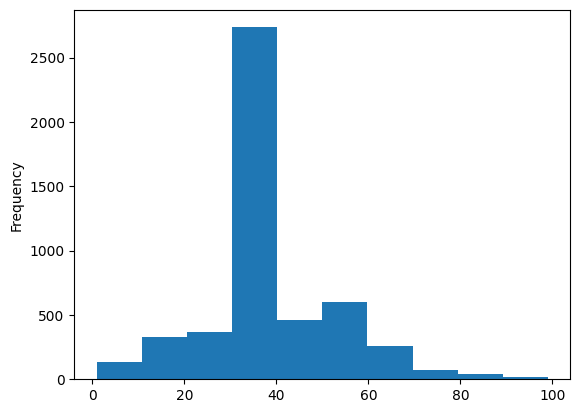

In [14]:
# Value distribution plot for "hours-per-week" (requires matplotlib)
df['hours-per-week'].plot.hist()

#### Measuring noise in numeric variables

We will measure the signal-to-noise ratio (SNR) of the 6 numeric variables to determine if any has a high noise.

According to [this Wikipedia article](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), the SNR can be calculated as (μ^2/σ^2).

Let us find μ (the means) and σ (the standard deviations) to apply the formula.

In [15]:
# Get mean and STD of the the numerical variables
numericInfo = df.describe().iloc[1:3]
numericInfo

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
mean,38.504800,187269.876000,10.038400,1107.090200,89.561400,40.20600
std,13.779781,102781.411899,2.595433,7708.019951,408.651437,12.45805


Now, let us compute the SNR.

In [16]:
# Calculate SNRs and store them in variables
resultage = ( (numericInfo['age'][0])**2 ) / ( (numericInfo['age'][1])**2 )
resultweight = ( (numericInfo['fnlwgt'][0])**2 ) / ( (numericInfo['fnlwgt'][1])**2 )
resultedu = ( (numericInfo['educational-num'][0])**2 ) / ( (numericInfo['educational-num'][1])**2 )
resultcapg = ( (numericInfo['capital-gain'][0])**2 ) / ( (numericInfo['capital-gain'][1])**2 )
resultcapl = ( (numericInfo['capital-loss'][0])**2 ) / ( (numericInfo['capital-loss'][1])**2 )
resulthpw = ( (numericInfo['hours-per-week'][0])**2 ) / ( (numericInfo['hours-per-week'][1])**2 )
# Output the variables
def SNRs():
    return {"Age": resultage, "Final Weight": resultweight, "Education-Num": resultedu, "Capital Gain": resultcapg, "Capital Loss": resultcapl, "Hours per Week": resulthpw}
SNRs()

{'Age': 7.8080958880742415,
 'Final Weight': 3.319759996517732,
 'Education-Num': 14.959233262883458,
 'Capital Gain': 0.02062910339656595,
 'Capital Loss': 0.04803255474767841,
 'Hours per Week': 10.415535705359764}

As we can see, the signal is significantly stronger than the noise for most variables. However, the two variables "capital-gain" and "capital-loss" have a very weak SNR.

The high noise in the capital related data might make its analysis difficult. Feature Engineering might be a solution to make more useful data from "capital-gain" and "capital-loss".

### Subsubtask 1.2.2 Checking for inconsistencies

Let us make sure Capital Gains VS Losses are mutually exclusive.

In [17]:
# Output entries with non-zero capital gains AND losses, if any
def capitalInconsistencies():
    inconsistent_data = df[(df['capital-gain'] > 0) & (df['capital-loss'] > 0)]
    if not inconsistent_data.empty:
        return inconsistent_data
    else:
        return "Empty Dataset"
capitalInconsistencies()

'Empty Dataset'

We note that there is no entry with capital gains AND losses.

### Subsubtask 1.2.3 Checking for duplicates

In [18]:
# Output entries that are identical, if any
def duplicatesInDf():
    duplicates = df[df.duplicated(keep=False)]
    if not duplicates.empty:
        return duplicates
    else:
        return "Empty Dataset"
duplicatesInDf()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
488,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K
864,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K


Seeing as there is one duplicate, let us drop it.

In [19]:
# Remove duplicates
df.drop_duplicates(inplace=True)
# Search for duplicates
duplicatesInDf()

'Empty Dataset'

In [20]:
# Make sure that there are still no missing values somehow
assert df.isnull().sum().sum() == 0
True

True

# Task 2

>[Convert categorical features to numerical values using encoding techniques]

**To avoid confusion: We will use the term "categorical" interchangeably with "nominal". We will NOT consider the "income" variable as a feature but rather as a class. We will always subtract the index column when counting the columns.**

**Explanation: Our dataset has 15 columns (excluding the index column), and 14 features (excluding the income variable). These 14 features consist of 8 categorical (nominal) variables, and 6 numerical variables.**

#### Encoding education

As already mentioned in [1.2.1](#Subsubtask-1.2.1-Checking-for-noisy-data), there are 8 nominal variables. Education is already ordinally encoded, so let us drop the non-numerical variable.

In [21]:
# Remove variable "education"
df.drop(columns='education',inplace=True)

In [22]:
# (debug) Get snippet of the updated DataFrame
df.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Private,103497,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K


We note that **the number of columns has decreased from 15 to 14.** The number of features has decreased from 14 to 13 (i.e. 7 nominal + 6 numerical).

#### Encoding workclass, marital-status, occupation, relationship, race, gender

Since the remaining 7 nominal variables are not ordinal, we do not want to use e.g. label encoding, as that could introduce unintended biases. Instead, we will use One-Hot encoding for them.

Let us apply One-Hot Encoding.

In [23]:
# Select the 7 nominal columns
categorical_cols = df[['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']].columns

# Select the other 7 columns (6 numericals + "income")
numeric_cols = df.columns.difference(categorical_cols)

In [24]:
# Perform one-hot encoding on categorical columns
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_array = onehot_encoder.fit_transform(df[categorical_cols])
column_names = onehot_encoder.get_feature_names_out(categorical_cols)
onehot_df = pd.DataFrame(onehot_array, columns=column_names)

# Concatenate one-hot encoded DataFrame with original numerical and income columns
numeric_df = df[numeric_cols].reset_index(drop=True)
encoded_df = pd.concat([numeric_df, onehot_df], axis=1)

# Get snippet of the processed DataFrame
encoded_df.head()

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,0,0,7,226802,40,<=50K,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38,0,0,9,89814,50,<=50K,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28,0,0,12,336951,40,>50K,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44,7688,0,10,160323,40,>50K,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,18,0,0,10,103497,30,<=50K,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The increase in the number of columns from 14 to 87 after one-hot encoding indicates that there were 73 unique categorical values across the 7 encoded categorical columns. One-hot encoding created a new binary column for each unique value, resulting in the increase in the number of columns. This is a common outcome of one-hot encoding, and it enables us to represent categorical variables as numerical variables in a way that can be easily processed by machine learning algorithms.

#### Encoding income

The class of our dataset - "income" - only has two categories. We can simply apply binary encoding.

In [25]:
# Replace "income" value "<=50K" with 0, and "income" value ">50K" with 1
encoded_df['income'].replace('<=50K', 0, inplace=True)
encoded_df['income'].replace('>50K', 1, inplace=True)
df = encoded_df.copy()

In [26]:
# (debug) Show information about of fully encoded dataset
df.describe()

,age,capital-gain,capital-loss,educational-num,fnlwgt,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,4999.000000,4999.000000,4999.000000,4999.000000,4.999000e+03,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,...,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.0000
mean,38.507702,1107.311662,89.579316,10.037808,1.872684e+05,40.207041,0.234447,0.029606,0.061812,0.746949,...,0.001200,0.004401,0.001000,0.002801,0.000600,0.001000,0.000200,0.918184,0.001200,0.0004
std,13.779631,7708.775114,408.690353,2.595355,1.027916e+05,12.459078,0.423695,0.169514,0.240839,0.434803,...,0.034627,0.066200,0.031613,0.052851,0.024492,0.031613,0.014144,0.274112,0.034627,0.0200
min,17.000000,0.000000,0.000000,1.000000,1.376900e+04,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,27.000000,0.000000,0.000000,9.000000,1.154385e+05,39.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000
50%,37.000000,0.000000,0.000000,10.000000,1.775430e+05,40.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000
75%,48.000000,0.000000,0.000000,12.000000,2.362120e+05,45.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000
max,90.000000,99999.000000,3175.000000,16.000000,1.047822e+06,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000


# Task 3

>How can you scale the continuous features in your dataset? Consider using techniques such as min-max scaling and normalization.

In [27]:
# Select continuous columns
continuous_cols = ['age', 'capital-gain', 'capital-loss', 'educational-num', 'fnlwgt', 'hours-per-week']

#### Min-Max Scaling

To scale the continuous features in the processed_df dataset, we can use either Min-Max Scaling or other normalization techniques. Here's an example of how to apply these techniques using scikit-learn.

Let us apply Min-Max Scaling first.

In [28]:
# Perform min-max scaling
min_max_scaler = MinMaxScaler()
minmax_df = df.copy()
minmax_df[continuous_cols] = min_max_scaler.fit_transform(minmax_df[continuous_cols])

#### Standardization

Let us try Standardization instead.

In [29]:
# Perform standardization
standard_scaler = StandardScaler()
standard_df = df.copy()
standard_df[continuous_cols] = standard_scaler.fit_transform(standard_df[continuous_cols])

#### Comparing normalization techniques

We have tried 3 different normalization techniques: (1) Not normalizing at all, (2) Min-Max Scaling & (3) Standardization.

At this point we cannot say which is better because we do not have an ML model. However, we can plot the data in its normalized and raw form to get an idea. Let us make three boxplots, excluding "capital-loss" and "capital-gains" because visualizing them would serve a very limited use (cf. [1.2.1](#Measuring-noise-in-numeric-variables)).

<Axes: >

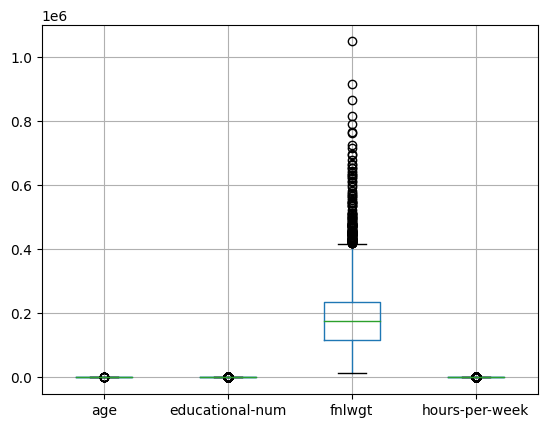

In [30]:
# Boxplot the continuous features in processed_df
df[['age', 'educational-num', 'fnlwgt', 'hours-per-week']].boxplot()

<Axes: >

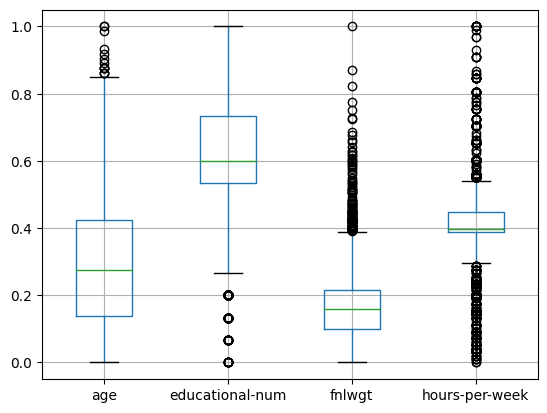

In [31]:
# Boxplot the continuous features in minmax_df
minmax_df[['age', 'educational-num', 'fnlwgt', 'hours-per-week']].boxplot()

<Axes: >

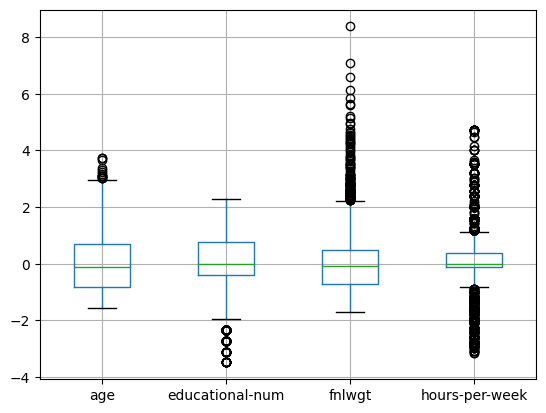

In [32]:
# Boxplot the continuous features in standard_df
standard_df[['age', 'educational-num', 'fnlwgt', 'hours-per-week']].boxplot()

<h1><span style="color:red">Task 4</span></h1>

>Check for outliers in the dataset features and handle them using appropriate techniques like removing outliers, imputation, winsorization, transformation, and bin binning.

From the Box Plots above, we can guess that the outliers in the continuous variables play a big role. The continuous variables "capital-gain" and "capital-loss" have an even bigger share of outliers.

#### Identifying the outliers

##### Bugged Code

The code below is not functional as of now

In [33]:
#cont_df = df[continuous_cols].copy()

In [34]:
# Compute interquartile range (IQR) for each continuous feature
#q1 = cont_df.quantile(0.25)
#q3 = cont_df.quantile(0.75)
#iqr = q3 - q1
# Compute lower and upper bounds for identifying outliers
#lower_bound = q1 - 1.5 * iqr
#upper_bound = q3 + 1.5 * iqr

In [35]:
# Identify potential outliers
#outliers = {}
#outliers = cont_df[(cont_df[col] < lower_bound[col]) | (cont_df[col] > upper_bound[col])]
#outliers

# Task 5

>Analyse the dataset and determine if the target variable 'class' is balanced or not.

>[...] balance it using techniques [like under-sampling].

#### Determining if the dataset is balanced

First, we need to calculate the proportion of each class in the target variable. Let us count the number of occurrences of each class (<=50K and >50K) and calculate the percentage of each class.

In [36]:
income_counts = df['income'].value_counts()
income_percentage = df['income'].value_counts(normalize=True) * 100

print("Counts of each class:")
print(income_counts)
print("\nPercentage of each class:")
print(income_percentage)

Counts of each class:
income
0    3827
1    1172
Name: count, dtype: int64

Percentage of each class:
income
0    76.555311
1    23.444689
Name: proportion, dtype: float64


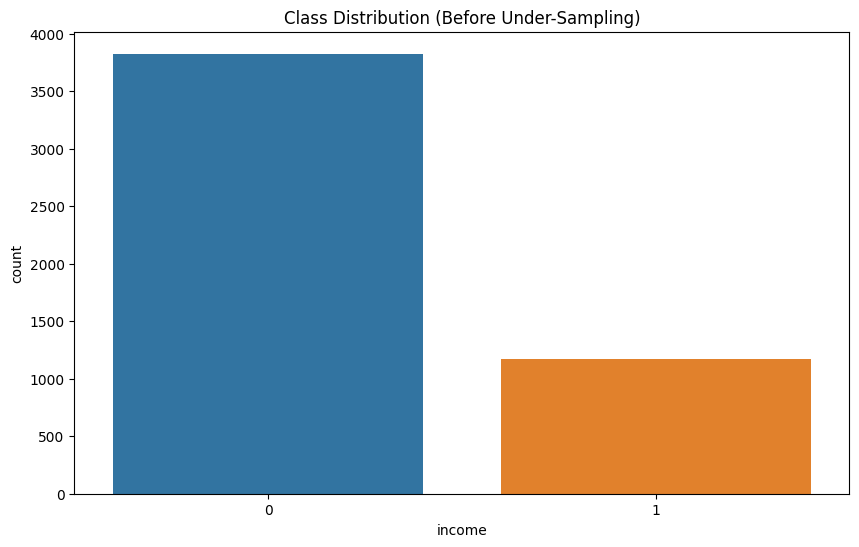

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(x='income', data=df)
plt.title("Class Distribution (Before Under-Sampling)")
plt.show()

#### Undersampling the data

We chose random under-sampling because it's simple: Eliminating instances from the majority class. It's useful when the dataset is large enough for model performance to remain the same. NB: Random under-sampling can potentially remove important information from the majority class, especially when there is a high imbalance ratio.


Counts of each class after random under-sampling:
Counter({0: 1172, 1: 1172})


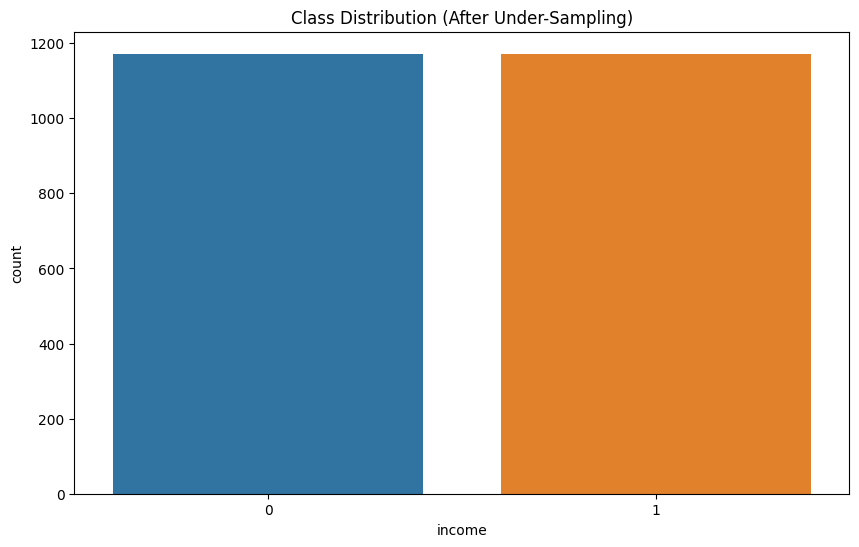

In [38]:
X = df.drop('income', axis=1)
y = df['income']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("\nCounts of each class after random under-sampling:")
print(Counter(y_resampled))

resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='income', data=resampled_data)
plt.title("Class Distribution (After Under-Sampling)")
plt.show()

<h1><span style="color:red">Task 6</span></h1>

>Analyse the dataset and create new features/derived features. [...] This can help the model better capture patterns.

<h1><span style="color:red">Task 7</span></h1>

>Identify:

>[1.] The relevant features that are likely to have a significant impact [on income]

>[2.] The irrelevant or redundant features [...] to the prediction task.